In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
import camb
from camb import model, initialpower

In [2]:
#--------------------------Estableciendo, ajustando y cambiando cosmologías------------------------

In [3]:
from colossus.cosmology import cosmology  
from colossus.halo import mass_so
from colossus.lss import mass_function
from colossus.lss import bias

In [4]:
cosmo = cosmology.setCosmology('planck15')  #Se impone esta cosmología globalmente

In [5]:
for k in cosmology.cosmologies:  
    print(k)

planck18-only
planck18
planck15-only
planck15
planck13-only
planck13
WMAP9-only
WMAP9-ML
WMAP9
WMAP7-only
WMAP7-ML
WMAP7
WMAP5-only
WMAP5-ML
WMAP5
WMAP3-ML
WMAP3
WMAP1-ML
WMAP1
illustris
bolshoi
multidark-planck
millennium
EdS
powerlaw


In [6]:
print(cosmo)   # k=0, Omega_m_0=0.3089, Omega_lambda_0=0.6910, Omega_bariones_0=0.0486, H0, 
               # Sigma8 (la anchura de la distribución gaussiana de masas de un halo oscuro de 8 Mpc/h de tamaño en el
               # espectro de potencias), ns(tilt del espectro de potencias P(k) es prop. a k^(ns)), de_model=lambda
               # (ecuación de estado de la energía oscura, en este caso igual a labda, la usual), relativistic_species 
               # (neutrinos y fotones, se llevan parte de la densidad de energía del universo),T_CMB_0=2.7255 K, 
               # Neff (número efectivo de especies relativistas), Power_law(crea otra relación P(k)=k^(n_powerlaw))

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [7]:
cosmo = cosmology.getCurrent()  #Como la cosmología se definió globalmente, se puede recuperar su nombre desde cualquier
print(cosmo.name)               #parte del código

planck15


In [8]:
cosmo2 = cosmology.setCosmology('WMAP9')    # Aún así, las cosmologías son objetos y se puede
cosmology.setCurrent(cosmo2)                # cambiar de uno a otro. 
print(cosmology.getCurrent().name)
cosmology.setCurrent(cosmo)
print(cosmology.getCurrent().name)

WMAP9
planck15


In [9]:
#También se puede definir una cosmología propia definiendo los párametros


my_cosmo = {'flat': True, 'H0': 72.0, 'Om0': 0.25, 'Ob0': 0.043, 'sigma8': 0.8, 'ns': 0.97}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
print(cosmo)

# Notar que aunque Omega_m_0=0.25, Omega_labda_0 no es exactamente 0.75 sino un poco menos debido a la parte de energía que 
# se llevan las especies relativistas. En la práctica, la contribución relativista es muy pequeña salvo para redshifts muy
# altos y es despreciable para la mayoría de los cálculos.

Cosmology "my_cosmo" 
    flat = True, Om0 = 0.2500, Ode0 = 0.7499, Ob0 = 0.0430, H0 = 72.00, sigma8 = 0.8000, ns = 0.9700
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [10]:
#Se puede cambiar un parámetro de una cosmología ya creada, pero hay que avisar a Colossus para que borre su caché.

cosmo.Om0 = 0.27
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "my_cosmo" 
    flat = True, Om0 = 0.2700, Ode0 = 0.7299, Ob0 = 0.0430, H0 = 72.00, sigma8 = 0.8000, ns = 0.9700
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [11]:
# Hasta ahora hemos usado cosmologías lambda-CDM planas, que usan una constante para la energía oscura cosmológica  
# calculada a partir de las ecuaciones de materia y relativistas.

In [12]:
# Para introducir curvatura hay que cambiar el flat=True. 

params = cosmology.cosmologies['planck15']
params['flat'] = False
params['Ode0'] = 0.75
cosmo = cosmology.setCosmology('planck_curvature', params)
print(cosmo.Ok0)

-0.05899117075465279


In [13]:
# En estos casos de curvatura no nula, la expresión de la energía oscura hay que escribirla explícitamente en función de w
# (P_lambda=w*densidad_labda). El caso lambda-CDM tiene w=-1. También se pueden introducir otros valores constantes, una
# variación lineal w(z) = w0 + wa*(1-a) o una función w(z) propia definida por el usuario.

In [14]:
# Para introducir la función lineal:

params = cosmology.cosmologies['planck15']
params['de_model'] = 'w0wa'
params['w0'] = -0.8
params['wa'] = 0.1
cosmo = cosmology.setCosmology('planck_w0wa', params)
print(cosmo.wz(0.5))

-0.7666666666666667


In [15]:
#Para introducir una función w(z) arbitraria definida por el usuario:

def wz_func(z):
    return -1.0 + 0.1 * z

params = cosmology.cosmologies['planck15']
params['de_model'] = 'user'
params['wz_function'] = wz_func
cosmo = cosmology.setCosmology('planck_wz', params)
print(cosmo.wz(0.5))

-0.95


In [16]:
# Nota: en los casos de w(z) lineal o definidos por el usuario, el valor de z hacia el futuro (hacia valores menores que 1)
# está únicamente permitido hasta z = -0.9 (el crecimiento exponencial de la energía oscura podría llevar a errores si se
# continúa hacia el futuro.


In [17]:
#--------------------------------Cálculos estándar: densidades, distancias, tiempos----------------

In [18]:
# Volvemos a definir una cosmología. Para accederla podemos poner su nombre ("cosmo") o usar cosmology.getCurrent()

params = cosmology.cosmologies['planck15']
params['flat'] = True
params['de_model'] = 'lambda'
cosmo = cosmology.setCosmology('planck15', params)
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [19]:
# Edad del universo actual en Gyr. Siempre se toma como argumento el redshift z (y no el factor de escala a).

print(cosmo.age(0.0))


# Para hallarla usa t(z) = H0^(-1)*Integral_entre_z_y_inf{dz/[E(z)*(1+z)]}

13.797386576163275


In [20]:
# El sistema de unidades que usa Colossus es el siguiente:

# Length: comoving Mpc/h
# Mass: Msun
# Wavenumber: comoving h/Mpc
# Time: Gyr
# Density: physical Msun * h^2 / kpc^3

In [21]:
# Casi todas las funciones de Colossus aceptan arrays de numpy como variables de entrada y proporcionan arrays de la misma
# dimensión como salida.

z = np.array([0.0, 1.0, 2.0, 3.0])
cosmo.angularDiameterDistance(z)

# La distancia de diámetro angular es dist_diam_ang = d_perp/angulo = a*r*angulo = a*r = r/(1+z) (r es la coordenada
# geométrica,auneque si el universo es plano coincide con la comóvil Chi y por tanto dA = dFis).

array([8.81319796e-16, 1.15018565e+03, 1.19933116e+03, 1.10241255e+03])

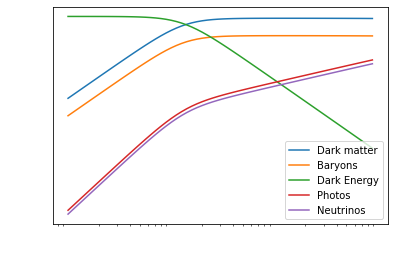

In [22]:
# Casi todas las funciones trabajan hasta z bastante extremos. (Desde z=-0.995 hasta z=200)
# Por ejemplo, vamos a representar la variación de las omegas en función de z+1 (en escala logarítmica).

zp1 = 10**np.arange(-1.0, 2.0, 0.05)   # Se establece que el eje x [zp1=(z+1)] tenga valores de 10^(-1) hasta 10^(2) con un 
z = zp1 - 1.0                          # paso para el exponente de 0.05. Luego para tener la variable z se le resta 1.

O_b = cosmo.Ob(z)          #Bariones
O_dm = cosmo.Om(z) - O_b   #Materia oscura = materia - bariones
O_de = cosmo.Ode(z)        #Energía oscura
O_gamma = cosmo.Ogamma(z)  #Radiación (fotones)
O_nu = cosmo.Onu(z)        #Neutrinos 

plt.figure()
plt.loglog()  # Para hacer que los dos ejes tengan escala log
plt.xlabel('z+1')
plt.ylabel('Fraction of total density')
plt.plot(zp1, O_dm, '-', label = 'Dark matter')
plt.plot(zp1, O_b, '-', label = 'Baryons')
plt.plot(zp1, O_de, '-', label = 'Dark Energy')
plt.plot(zp1, O_gamma, '-', label = 'Photos')
plt.plot(zp1, O_nu, '-', label = 'Neutrinos')
plt.legend(loc = 4)
ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
plt.savefig('Presentación/Omegas_segun_z.png',dpi=300)

In [23]:
#También podemos invertir las funciones. Aquí pasamos de t(z) a z(t)

z = np.array([0.0, 1.0, 2.0, 3.0])
t = cosmo.age(z)
z2 = cosmo.age(t, inverse = True)
print(z2)

# Halla estos valores mediante interpolación (como en la mayoría de los casos). Si no queremos que interpole sino que 
# queremos el cálculo exacto, podemos escribir interpolation = False. 

[-4.34718719e-05  9.99787352e-01  1.99991496e+00  3.00002254e+00]


In [24]:
# También usando interpolación, podemos obtener las derivadas de la función t(z).

In [25]:
cosmo.age(z, derivative = 1)  # derivada primera dt/dz

array([-14.43560477,  -4.05678977,  -1.60037067,  -0.79726554])

In [26]:
cosmo.age(z, derivative = 2)  # derivada segunda d^2t/dz^2

array([21.12575913,  4.41094814,  1.27172717,  0.48664907])

In [27]:
# Incluso se puede combinar la derivación con la inversión para obtener dz/dt

t = cosmo.age(z)
cosmo.age(t, inverse = True, derivative = 1)

array([-0.06928475, -0.24595949, -0.6259051 , -1.25408459])

In [28]:
# -------------------------------------------------------------------------------------------------

In [29]:
# En la práctica tenía un gráfico de la d_L(z)*H0 para una cosmología plana, sin especies rel., w = -1 y 
# Omega_m = 0.3, H0 = 69.96266.

In [30]:
# La cosmología planck15 ya tiene w = -1, y su Omega_m = 0.3089. También tiene en cuenta las especies relativistas.

cosmo = cosmology.setCosmology('planck15')    
cosmology.setCurrent(cosmo)


params = cosmology.cosmologies['planck15']
params['flat'] = True
params['de_model'] = 'lambda'
h=0.6774
cosmo = cosmology.setCosmology('planck15', params)

print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [31]:
# Vamos a usar esta cosmología primero, con las especies relativistas y la Omega_m sin ser
# exactamente 0.3.

z = np.linspace(0,1.5,num=100)
d_L_planck = cosmo.luminosityDistance(z, derivative=0, inverse=False)
d_L_planck = d_L_planck/h

In [32]:
# Ahora vamos a obtener los parámetros exactos de la práctica. Se entiende que se ignoran las especies relativistas y que
# Omega_m = 0.30 exactamente.

params = cosmology.cosmologies['planck15']
params['Om0'] = 0.30
params['H0'] = 300000/4285      #69.96266 
h=0.701
params['relspecies'] = False
cosmo = cosmology.setCosmology('Cosmología práctica', params)
print(cosmo)

Cosmology "Cosmología práctica" 
    flat = True, Om0 = 0.3000, Ode0 = 0.7000, Ob0 = 0.0486, H0 = 70.01, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [33]:
z = np.linspace(0,1.5,num=100,endpoint=True)
d_L_practica_colossus = cosmo.luminosityDistance(z, derivative=0, inverse=False)
d_L_practica_colossus = d_L_practica_colossus/h

In [34]:
# Ahora usamos la cosmología y función de la práctica directamente

def d_L_funcion(z,W,w,H0_inversa_entre_h):
    return quad(lambda y: (1+z)*H0_inversa_entre_h*((W*((1+y) ** 3) + (1-W) * ((1+y) ** (3*(1+w)))) ** (-1/2)),0,z)[0]
d_L_funcion=np.vectorize(d_L_funcion)

W=0.3
w=-1
H0_inversa_entre_h=4285 #Mpc 

In [35]:
z = np.linspace(0,1.5,num=100,endpoint=True)
d_L_practica_original=d_L_funcion(z,W,w,H0_inversa_entre_h)

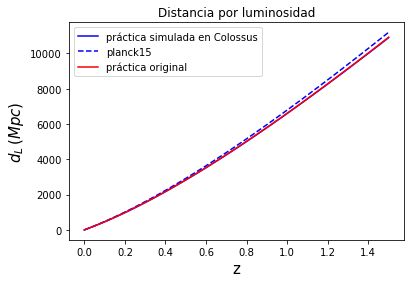

In [36]:
plt.figure()
plt.plot(z,d_L_practica_colossus,'b',label='práctica simulada en Colossus')
plt.plot(z,d_L_planck,'b--',label='planck15')
plt.plot(z,d_L_practica_original,'r',label='práctica original')
plt.xlabel('z',fontsize=15)
plt.ylabel(r'$d_L \, (Mpc)$',fontsize=15)
plt.title('Distancia por luminosidad')
plt.legend()
plt.show()

# No coincide con la de la práctica (quizás porque Colossus
# no usa c=1)

In [37]:
#--------------------- Espectro de potencias, variancia y función de correlación-------------------

In [38]:
params = cosmology.cosmologies['planck15']
params['Om0'] = 0.3089
params['H0'] = 67.74
params['relspecies'] = True
cosmo = cosmology.setCosmology('planck15', params)
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


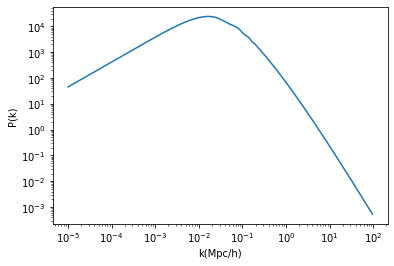

In [39]:
k = 10**np.arange(-5,2,0.02)
Pk = cosmo.matterPowerSpectrum(k)

plt.figure()
plt.loglog()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-');

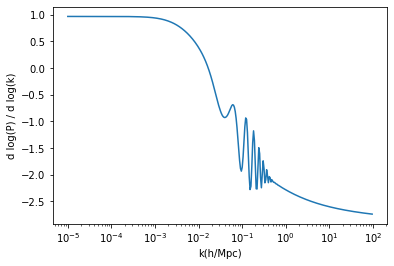

In [40]:
# A esas escalas, es difícil discernir comportamientos locales. Por ello se usa la siguiente 
# función, que calcula la derivada de P(k) para resaltar las ondulaciones del BAO (Barion Acoustic
# Oscilations).


Pk_deriv = cosmo.matterPowerSpectrum(k, derivative = True)

plt.figure()
plt.xscale('log')
plt.xlabel('k(h/Mpc)')
plt.ylabel('d log(P) / d log(k)')
plt.plot(k, Pk_deriv, '-');

In [41]:
#------------------------------CAMB---------------------------------------------------------------

In [42]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [43]:
#calculate results for these parameters
results = camb.get_results(pars)
print(results)

class: <CAMBdata>
 Params: <CAMBparams>
   WantCls = True
   WantTransfer = False
   WantScalars = True
   WantTensors = False
   WantVectors = False
   WantDerivedParameters = True
   Want_cl_2D_array = True
   Want_CMB = True
   Want_CMB_lensing = True
   DoLensing = True
   NonLinear = NonLinear_none
   Transfer: <TransferParams>
     high_precision = False
     accurate_massive_neutrinos = False
     kmax = 0.9
     k_per_logint = 0
     PK_num_redshifts = 1
     PK_redshifts = [0.0]
   want_zstar = False
   want_zdrag = False
   min_l = 2
   max_l = 2650
   max_l_tensor = 600
   max_eta_k = 6625.0
   max_eta_k_tensor = 1200.0
   ombh2 = 0.022
   omch2 = 0.122
   omk = 0.0
   omnuh2 = 0.0006451383989381787
   H0 = 67.5
   TCMB = 2.7255
   YHe = 0.24524332588411976
   num_nu_massless = 2.030666666666667
   num_nu_massive = 1
   nu_mass_eigenstates = 1
   share_delta_neff = False
   nu_mass_degeneracies = [1.0153333333333332]
   nu_mass_fractions = [1.0]
   nu_mass_numbers = [1]
   I

In [44]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 500)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 500)

Note: redshifts have been re-sorted (earliest first)


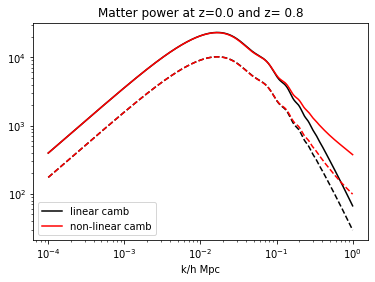

In [45]:
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, pk[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.legend(['linear camb','non-linear camb'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z));

#Las líneas continuas son las de z=0 y están más arriba debido a que la fluctuación de densidad a
#una k (escala) concreta va creciendo con el tiempo.


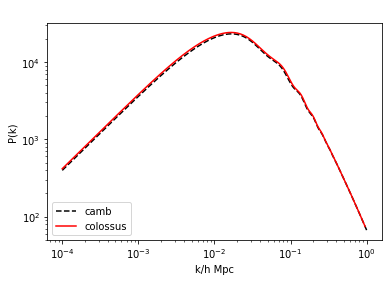

In [46]:
#Now get matter power spectra and sigma8 at redshift 0
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2)

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 2000)
s8 = np.array(results.get_sigma8())
# el pk proporcionado por camb es de dimension (1,n) así que para representarlo hay que pk[0,:] 
pk=pk[0,:]



k = 10**np.arange(-4,0,0.02)
Pk = cosmo.matterPowerSpectrum(k)






plt.plot(kh, pk, color='k', ls = line,label='camb')
plt.plot(k, Pk, 'r-',label='colossus')
plt.xlabel('k/h Mpc')
plt.ylabel('P(k)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
title_obj = plt.title('Lineal Matter power at z=0.0')           
plt.setp(title_obj, color='white')


#ax = plt.gca()
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.savefig('Presentación/Espectro_lineal_colossus_camb.png',dpi=300)
plt.show()

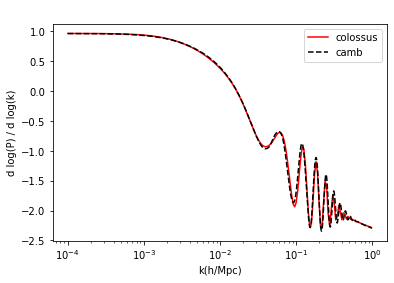

In [47]:
# Ahora vamos a representar las derivadas

Pk_deriv_1 = cosmo.matterPowerSpectrum(k, derivative = True)
derivada_pk_respecto_kh_1 = np.diff(np.log10(pk))/np.diff(np.log10(kh))      

#la derivada tiene un elemento menos que los arrays de los que se calcula


plt.figure()
plt.xscale('log')
plt.xlabel('k(h/Mpc)')
plt.ylabel('d log(P) / d log(k)')
plt.plot(k, Pk_deriv_1, 'r-',label='colossus')
plt.plot(kh[:(len(kh)-1)], derivada_pk_respecto_kh_1, color='k', ls = line,label='camb')
title_obj = plt.title(r'$\Omega_{b0}=0.0486$')          
plt.setp(title_obj, color='white')
plt.legend()
ax = plt.gca()
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.savefig('Presentación/Espectro_bao_colossus_camb.png',dpi=300)
plt.show() 

In [48]:
params = cosmology.cosmologies['planck15']
params['Ob0'] = 0.10
cosmo = cosmology.setCosmology('planck15', params)
print(cosmo)


Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.1000, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [49]:
#Now get matter power spectra and sigma8 at redshift 0
pars = camb.CAMBparams()
#Dejar variables fuera y tener en cuenta que omch2 es la materia oscura así que cambiarla.
pars.set_cosmology(H0=67.5, ombh2=0.0455625, omch2=0.09518)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2)

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 2000)
pk=pk[0,:]
s8 = np.array(results.get_sigma8())

In [50]:
k = 10**np.arange(-4,0,0.02)
Pk_deriv_2 = cosmo.matterPowerSpectrum(k, derivative = True)
derivada_pk_respecto_kh_2 = np.diff(np.log10(pk))/np.diff(np.log10(kh)) 

In [51]:
params = cosmology.cosmologies['planck15']
params['Ob0'] = 0.15
cosmo = cosmology.setCosmology('planck15', params)
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.1500, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [52]:
#Now get matter power spectra and sigma8 at redshift 0
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.06834375, omch2=0.07239881)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2)

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 2000)
pk=pk[0,:]
s8 = np.array(results.get_sigma8())

In [53]:
k = 10**np.arange(-4,0,0.02)
Pk_deriv_3 = cosmo.matterPowerSpectrum(k, derivative = True)
derivada_pk_respecto_kh_3 = np.diff(np.log10(pk))/np.diff(np.log10(kh))

In [54]:
params = cosmology.cosmologies['planck15']
params['Ob0'] = 0.01
cosmo = cosmology.setCosmology('planck15', params)
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0100, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [55]:
#Now get matter power spectra and sigma8 at redshift 0
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.00455625, omch2=0.1361863125)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2)

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 2000)
pk=pk[0,:]
s8 = np.array(results.get_sigma8())

In [56]:
k = 10**np.arange(-4,0,0.02)
Pk_deriv_4 = cosmo.matterPowerSpectrum(k, derivative = True)
derivada_pk_respecto_kh_4 = np.diff(np.log10(pk))/np.diff(np.log10(kh)) 

In [57]:
params = cosmology.cosmologies['planck15']
params['Ob0'] = 0.03
cosmo = cosmology.setCosmology('planck15', params)
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0300, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [58]:
#Now get matter power spectra and sigma8 at redshift 0
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.01366875, omch2=0.1270738125)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2)

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 2000)
pk=pk[0,:]
s8 = np.array(results.get_sigma8())

In [59]:
k = 10**np.arange(-4,0,0.02)
Pk_deriv_5 = cosmo.matterPowerSpectrum(k, derivative = True)
derivada_pk_respecto_kh_5 = np.diff(np.log10(pk))/np.diff(np.log10(kh))

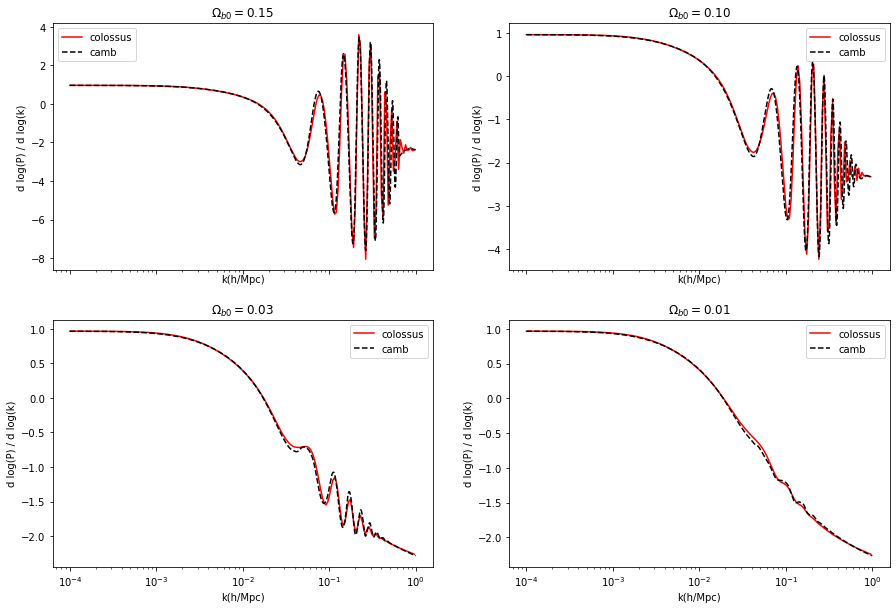

In [60]:
fig, ((ax2, ax1), (ax4, ax3)) = plt.subplots(2, 2, figsize=(15,10), sharex=True)
#title_obj = fig.suptitle('BAO de Colossus y CAMB para varios '+r'$\Omega_{b0}$'+' (a z=0)',fontsize=20)            
#plt.setp(title_obj, color='black')




ax1.set_xscale('log')
ax1.set_xlabel('k(h/Mpc)')
ax1.set_ylabel('d log(P) / d log(k)')
ax1.plot(k, Pk_deriv_2, 'r-',label='colossus')
ax1.plot(kh[:(len(kh)-1)], derivada_pk_respecto_kh_2, color='k', ls = line,label='camb')
title_obj = ax1.set_title(r'$\Omega_{b0}=0.10$')           
#plt.setp(title_obj, color='white')
ax1.legend()
 


ax2.set_xscale('log')
ax2.set_xlabel('k(h/Mpc)')
ax2.set_ylabel('d log(P) / d log(k)')
ax2.plot(k, Pk_deriv_3, 'r-',label='colossus')
ax2.plot(kh[:(len(kh)-1)], derivada_pk_respecto_kh_3, color='k', ls = line,label='camb')
title_obj = ax2.set_title(r'$\Omega_{b0}=0.15$')           
#plt.setp(title_obj, color='white')
ax2.legend()
 


ax3.set_xscale('log')
ax3.set_xlabel('k(h/Mpc)')
ax3.set_ylabel('d log(P) / d log(k)')
ax3.plot(k, Pk_deriv_4, 'r-',label='colossus')
ax3.plot(kh[:(len(kh)-1)], derivada_pk_respecto_kh_4, color='k', ls = line,label='camb')
title_obj = ax3.set_title(r'$\Omega_{b0}=0.01$')          
#plt.setp(title_obj, color='white')
ax3.legend()




ax4.set_xscale('log')
ax4.set_xlabel('k(h/Mpc)')
ax4.set_ylabel('d log(P) / d log(k)')
ax4.plot(k, Pk_deriv_5, 'r-',label='colossus')
ax4.plot(kh[:(len(kh)-1)], derivada_pk_respecto_kh_5, color='k', ls = line,label='camb')
title_obj = ax4.set_title(r'$\Omega_{b0}=0.03$')            
#plt.setp(title_obj, color='white')
ax4.legend()

#ax1.xaxis.label.set_color('white')
#ax1.tick_params(axis='x', colors='white')
#ax1.yaxis.label.set_color('white')
#ax1.tick_params(axis='y', colors='white')

#ax2.xaxis.label.set_color('white')
#ax2.tick_params(axis='x', colors='white')
#ax2.yaxis.label.set_color('white')
#ax2.tick_params(axis='y', colors='white')

#ax3.xaxis.label.set_color('white')
#ax3.tick_params(axis='x', colors='white')
#ax3.yaxis.label.set_color('white')
#ax3.tick_params(axis='y', colors='white')

#ax4.xaxis.label.set_color('white')
#ax4.tick_params(axis='x', colors='white')
#ax4.yaxis.label.set_color('white')
#ax4.tick_params(axis='y', colors='white')
plt.savefig('Presentación/4_espectros_omega_b.png',dpi=300)
plt.show()


#Duda: para la derivada de camb se ha usado np.diff que toma restas de valores. Está bien?
#¿Por qué las líneas de camb no coinciden con las de Colossus?¿Es por la poca precisión de esta
#integral?

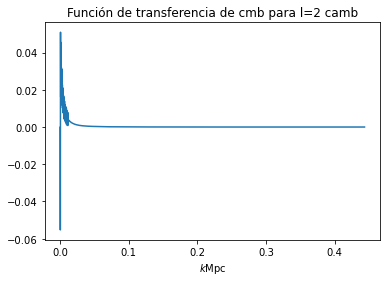

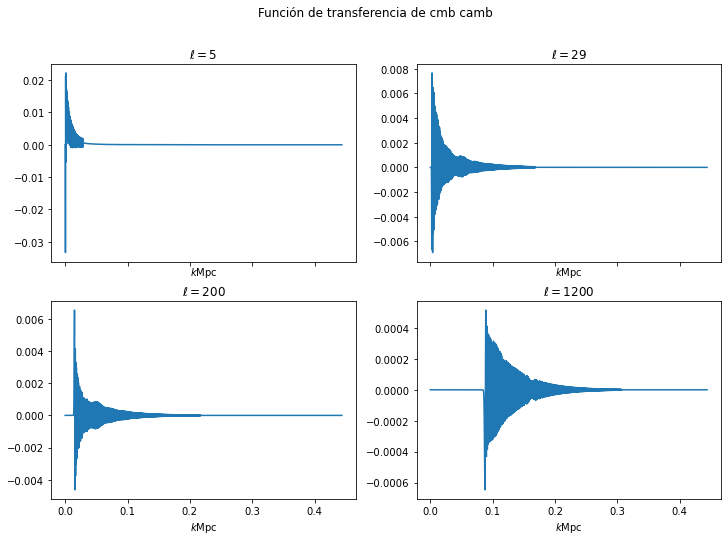

In [61]:
#------------------Función de trasnferencia camb-----------------------------

#transfer.q proporciona el array de k
#transfer.delta_p_l_k proporciona una matriz con 3 índices:
#uno para la función(T,E,phi,..), uno para la l(transfer.L, comienza en l=2
#y acaba en l=2500) y uno para la k(transfer.q).

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
data = camb.get_transfer_functions(pars)
transfer = data.get_cmb_transfer_data()
plt.plot(transfer.q,transfer.delta_p_l_k[0,0,:]) #La función T para l=2
plt.title('Función de transferencia de cmb para l=2 camb')
plt.xlabel(r'$k \rm{Mpc}$')
plt.show()




#Plot the transfer functions as a function of k for various l
fig, axs = plt.subplots(2,2, figsize=(12,8), sharex = True)
fig.suptitle('Función de transferencia de cmb camb')
for ix, ax in zip([3, 20, 40, 60],axs.reshape(-1)):
    ax.plot(transfer.q,transfer.delta_p_l_k[0,ix,:])
    ax.set_title(r'$\ell = %s$'%transfer.L[ix])
    if ix>1: ax.set_xlabel(r'$k \rm{Mpc}$')

Como se puede ver, la función T cubre rangos muy grandes para distintas l. Para tener una l con mayor resolución, se puede hacer lo siguiente:

In [62]:
#Función que te pinta con escala  mayor precisión para una l dada por el
#índice ix (recordar que a ix=0, l=2).

def plot_cmb_transfer_l(trans, ix):
    _, axs = plt.subplots(1,2, figsize=(12,6))
    for source_ix, (name, ax) in enumerate(zip(['T', 'E'], axs)):
        ax.semilogx(trans.q,trans.delta_p_l_k[source_ix,ix,:])
        ax.set_xlim([1e-5, 0.05])
        ax.set_xlabel(r'$k \rm{Mpc}$')
        ax.set_title(r'%s transfer function for $\ell = %s \;(cmb \; camb)$'%(name, trans.L[ix]))

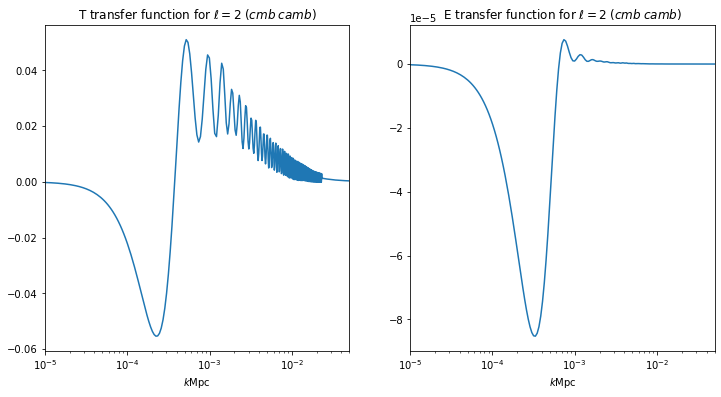

In [63]:
pars.set_accuracy(AccuracyBoost=2) #higher accuracy, so higher sampling density
data = camb.get_transfer_functions(pars)
transfer = data.get_cmb_transfer_data()
plot_cmb_transfer_l(transfer,0)
pars.set_accuracy(AccuracyBoost=1); #re-set default

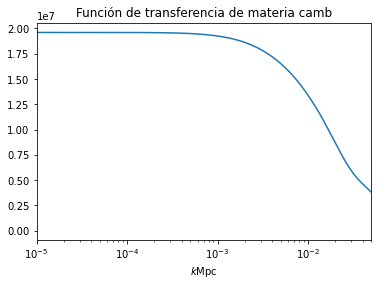

In [64]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.WantTransfer=True
data = camb.get_transfer_functions(pars)
transfer=data.get_matter_transfer_data()
plt.semilogx(transfer.q,transfer.transfer_z('delta_baryon', z_index=0)) #La función T para l=2
plt.title('Función de transferencia de materia camb')
plt.xlabel(r'$k \rm{Mpc}$')
plt.xlim([1e-5, 0.05])
plt.show()

In [65]:
#---------------- Función de transferencia Colossus ------------------------
params = cosmology.cosmologies['planck15']
params['Ob0'] = 0.0486
cosmo = cosmology.setCosmology('planck15',params)
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


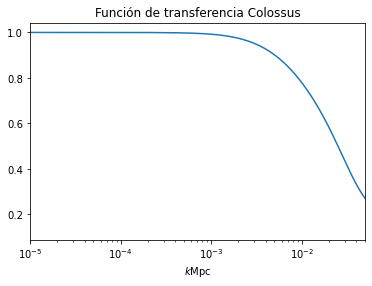

In [66]:
cosmo.checkForChangedCosmology()
h = params['H0']/100
k = np.linspace(1e-05,1e-1,500,endpoint=True)
Om0 = params['Om0']
Ob0 = params['Ob0']
# Esto da error y no sé por qué
#Tcmb0 = params['Tcmb0']
Tcmb0 = 2.7255

#La función de transferencia a z=0
Tk = cosmology.power_spectrum.transferFunction(k, h, Om0, Ob0, Tcmb0, model='eisenstein98')
plt.figure()
plt.semilogx(k,Tk)
plt.xlim([1e-5, 0.05])
plt.xlabel(r'$k \rm{Mpc}$')
plt.title('Función de transferencia Colossus')
plt.show()

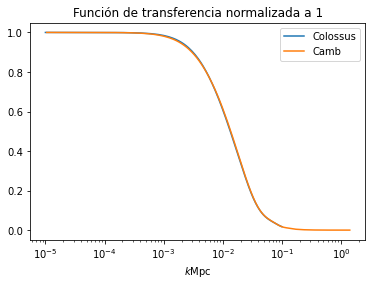

In [67]:
# plt.figure()
plt.semilogx(k,Tk**2/np.max(Tk**2),label='Colossus')
plt.semilogx(transfer.q/0.675,transfer.transfer_z('delta_baryon', z_index=0)**2/np.max(transfer.transfer_z('delta_tot', z_index=0)**2),label='Camb')
plt.xlabel(r'$k \rm{Mpc}$')
plt.legend()
plt.title('Función de transferencia normalizada a 1')
plt.show()

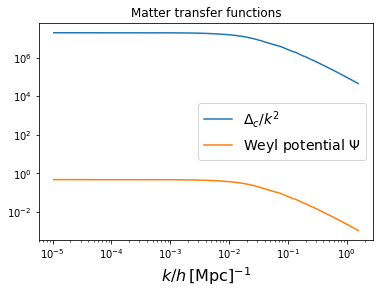

In [68]:
#You can also get the matter transfer functions
#These are synchronous gauge and normalized to unit primordial curvature perturbation
#The values stored in the array are quantities like Delta_x/k^2, and hence
#are nearly independent of k on large scales. 
#Indices in the transfer_data array are the variable type, the k index, and the redshift index

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=[0], kmax=1)
results= camb.get_results(pars)

trans = results.get_matter_transfer_data()
#get kh - the values of k/h at which they are calculated
kh = trans.transfer_data[0,:,0]
#transfer functions for different variables, e.g. CDM density and the Weyl potential
#CDM perturbations have grown, Weyl is O(1) of primordial value on large scales
delta = trans.transfer_data[model.Transfer_cdm-1,:,0]
W = trans.transfer_data[model.Transfer_Weyl-1,:,0]
plt.plot(kh,delta)
plt.loglog(kh,-W)
plt.xlabel(r'$k/h\, [\rm Mpc]^{-1}$', fontsize=16);
plt.title('Matter transfer functions')
plt.legend([r'$\Delta_c/k^2$',r'Weyl potential $\Psi$'], fontsize=14);

In [69]:
def M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c):
    v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    f=(Omega_b/Omega_m)*(0.75) # (1-Y)*Omega_b/Omega_m
    return alpha*f*M*((M*h/1e11)**beta)*np.exp(-(v_c0/v_c)**3)*np.exp(-(v_c/v_c1)**3)

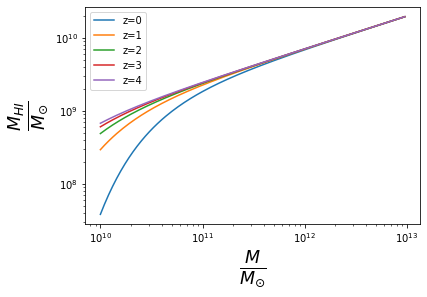

In [70]:
# Parámetros del paper (Best fit (WHISP))
Omega_m = 0.281
Omega_b = 0.0462
Omega_lambda = 0.719
h = 0.71
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s
M=10**np.arange(10,13,0.02)  #En unidades solares

#Sobredensidad crit 200
Delta_c = 200

z = 0
Masa_HI_0=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=1
Masa_HI_1=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=2
Masa_HI_2=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=3
Masa_HI_3=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=4
Masa_HI_4=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)


plt.figure()
plt.loglog(M,Masa_HI_0,label='z=0')
plt.loglog(M,Masa_HI_1,label='z=1')
plt.loglog(M,Masa_HI_2,label='z=2')
plt.loglog(M,Masa_HI_3,label='z=3')
plt.loglog(M,Masa_HI_4,label='z=4')
plt.xlabel(r'$\frac{M}{M_{\odot}}$',fontsize=25)
plt.ylabel(r'$\frac{M_{HI}}{M_{\odot}}$',fontsize=25)
plt.legend()
plt.show()

Restringir la beta a valores negativos hace que $M_{HI} \propto M^{0.algo}$ por lo que se da menos peso a los valores mayores de la M y el corte superior de la v está más arriba. Esto parece estar de acuerdo a las observaciones, que favorecen un perfil plano. Por eso en el gráfico anterior solo se ve el corte inferior. Para poder ver el superior hay que llegar hasta masas de $10^{20} M_{\odot}$.

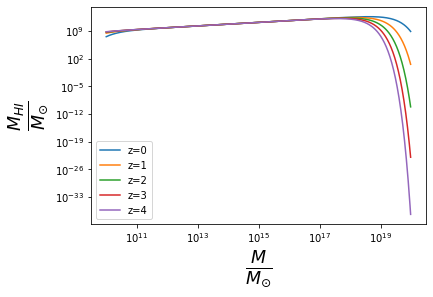

In [71]:
# Parámetros del paper (Best fit (WHISP))
Omega_m = 0.281
Omega_b = 0.0462
Omega_lambda = 0.719
h = 0.71
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s
M=10**np.arange(10,20,0.02)

#Sobredensidad crit 200
Delta_c = 200



z = 0
Masa_HI_0=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=1
Masa_HI_1=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=2
Masa_HI_2=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=3
Masa_HI_3=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=4
Masa_HI_4=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)


plt.figure()
plt.loglog(M,Masa_HI_0,label='z=0')
plt.loglog(M,Masa_HI_1,label='z=1')
plt.loglog(M,Masa_HI_2,label='z=2')
plt.loglog(M,Masa_HI_3,label='z=3')
plt.loglog(M,Masa_HI_4,label='z=4')
plt.xlabel(r'$\frac{M}{M_{\odot}}$',fontsize=25)
plt.ylabel(r'$\frac{M_{HI}}{M_{\odot}}$',fontsize=25)
plt.legend()
plt.show()

Sin embargo, hay una tensión para redshifts bajos entre la distribución de la columna de densidad de HI y la distribución de masas de las galaxias que lo contienen y parece que habrá que modificar el perfil para estos redshifts bajos.  

In [72]:
#Sobredensidad del paper para curvatura 0
def Delt_c(Omega_m,Omega_lambda,z):
    Omega_0 = Omega_m + Omega_lambda 
    E=(Omega_m*((1+z)**3) + Omega_lambda)**(1/2)
    Omega = (Omega_0*((1+z)**3))/(E**2)
    x = Omega - 1
    Delta_c = 18*np.pi**2 + 82*x - 39*x**2
    return Delta_c

177.65287921960845
204.52824433292267
164.65344904432826
147.48912662592494
140.3278802199257


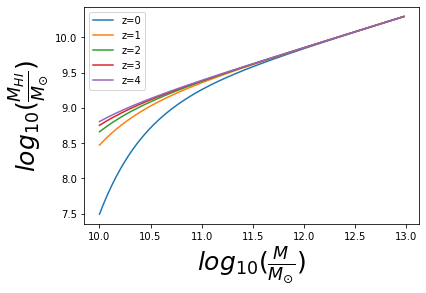

In [73]:
# Parámetros del paper (Best fit (WHISP))
Omega_m = 0.281
Omega_b = 0.0462
Omega_lambda = 0.719
h = 0.71
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s
M=10**np.arange(10,13,0.02)  #En unidades solares



z = 0
Delta_c=Delt_c(Omega_m,Omega_lambda,z)
print(Delta_c)
Masa_HI_0=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=1
Delta_c=Delt_c(Omega_m,Omega_lambda,z)
print(Delta_c)
Masa_HI_1=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=2
Delta_c=Delt_c(Omega_m,Omega_lambda,z)
print(Delta_c)
Masa_HI_2=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=3
Delta_c=Delt_c(Omega_m,Omega_lambda,z)
print(Delta_c)
Masa_HI_3=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=4
Delta_c=Delt_c(Omega_m,Omega_lambda,z)
print(Delta_c)
Masa_HI_4=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)


plt.figure()
plt.plot(np.log10(M),np.log10(Masa_HI_0),label='z=0')
plt.plot(np.log10(M),np.log10(Masa_HI_1),label='z=1')
plt.plot(np.log10(M),np.log10(Masa_HI_2),label='z=2')
plt.plot(np.log10(M),np.log10(Masa_HI_3),label='z=3')
plt.plot(np.log10(M),np.log10(Masa_HI_4),label='z=4')
plt.xlabel(r'$log_{10}(\frac{M}{M_{\odot}})$',fontsize=25)
plt.ylabel(r'$log_{10}(\frac{M_{HI}}{M_{\odot}})$',fontsize=25)
plt.legend()
plt.show()

98.53340021960845
155.4592890222865
170.1976274677346
174.35049304106332
175.874120143408


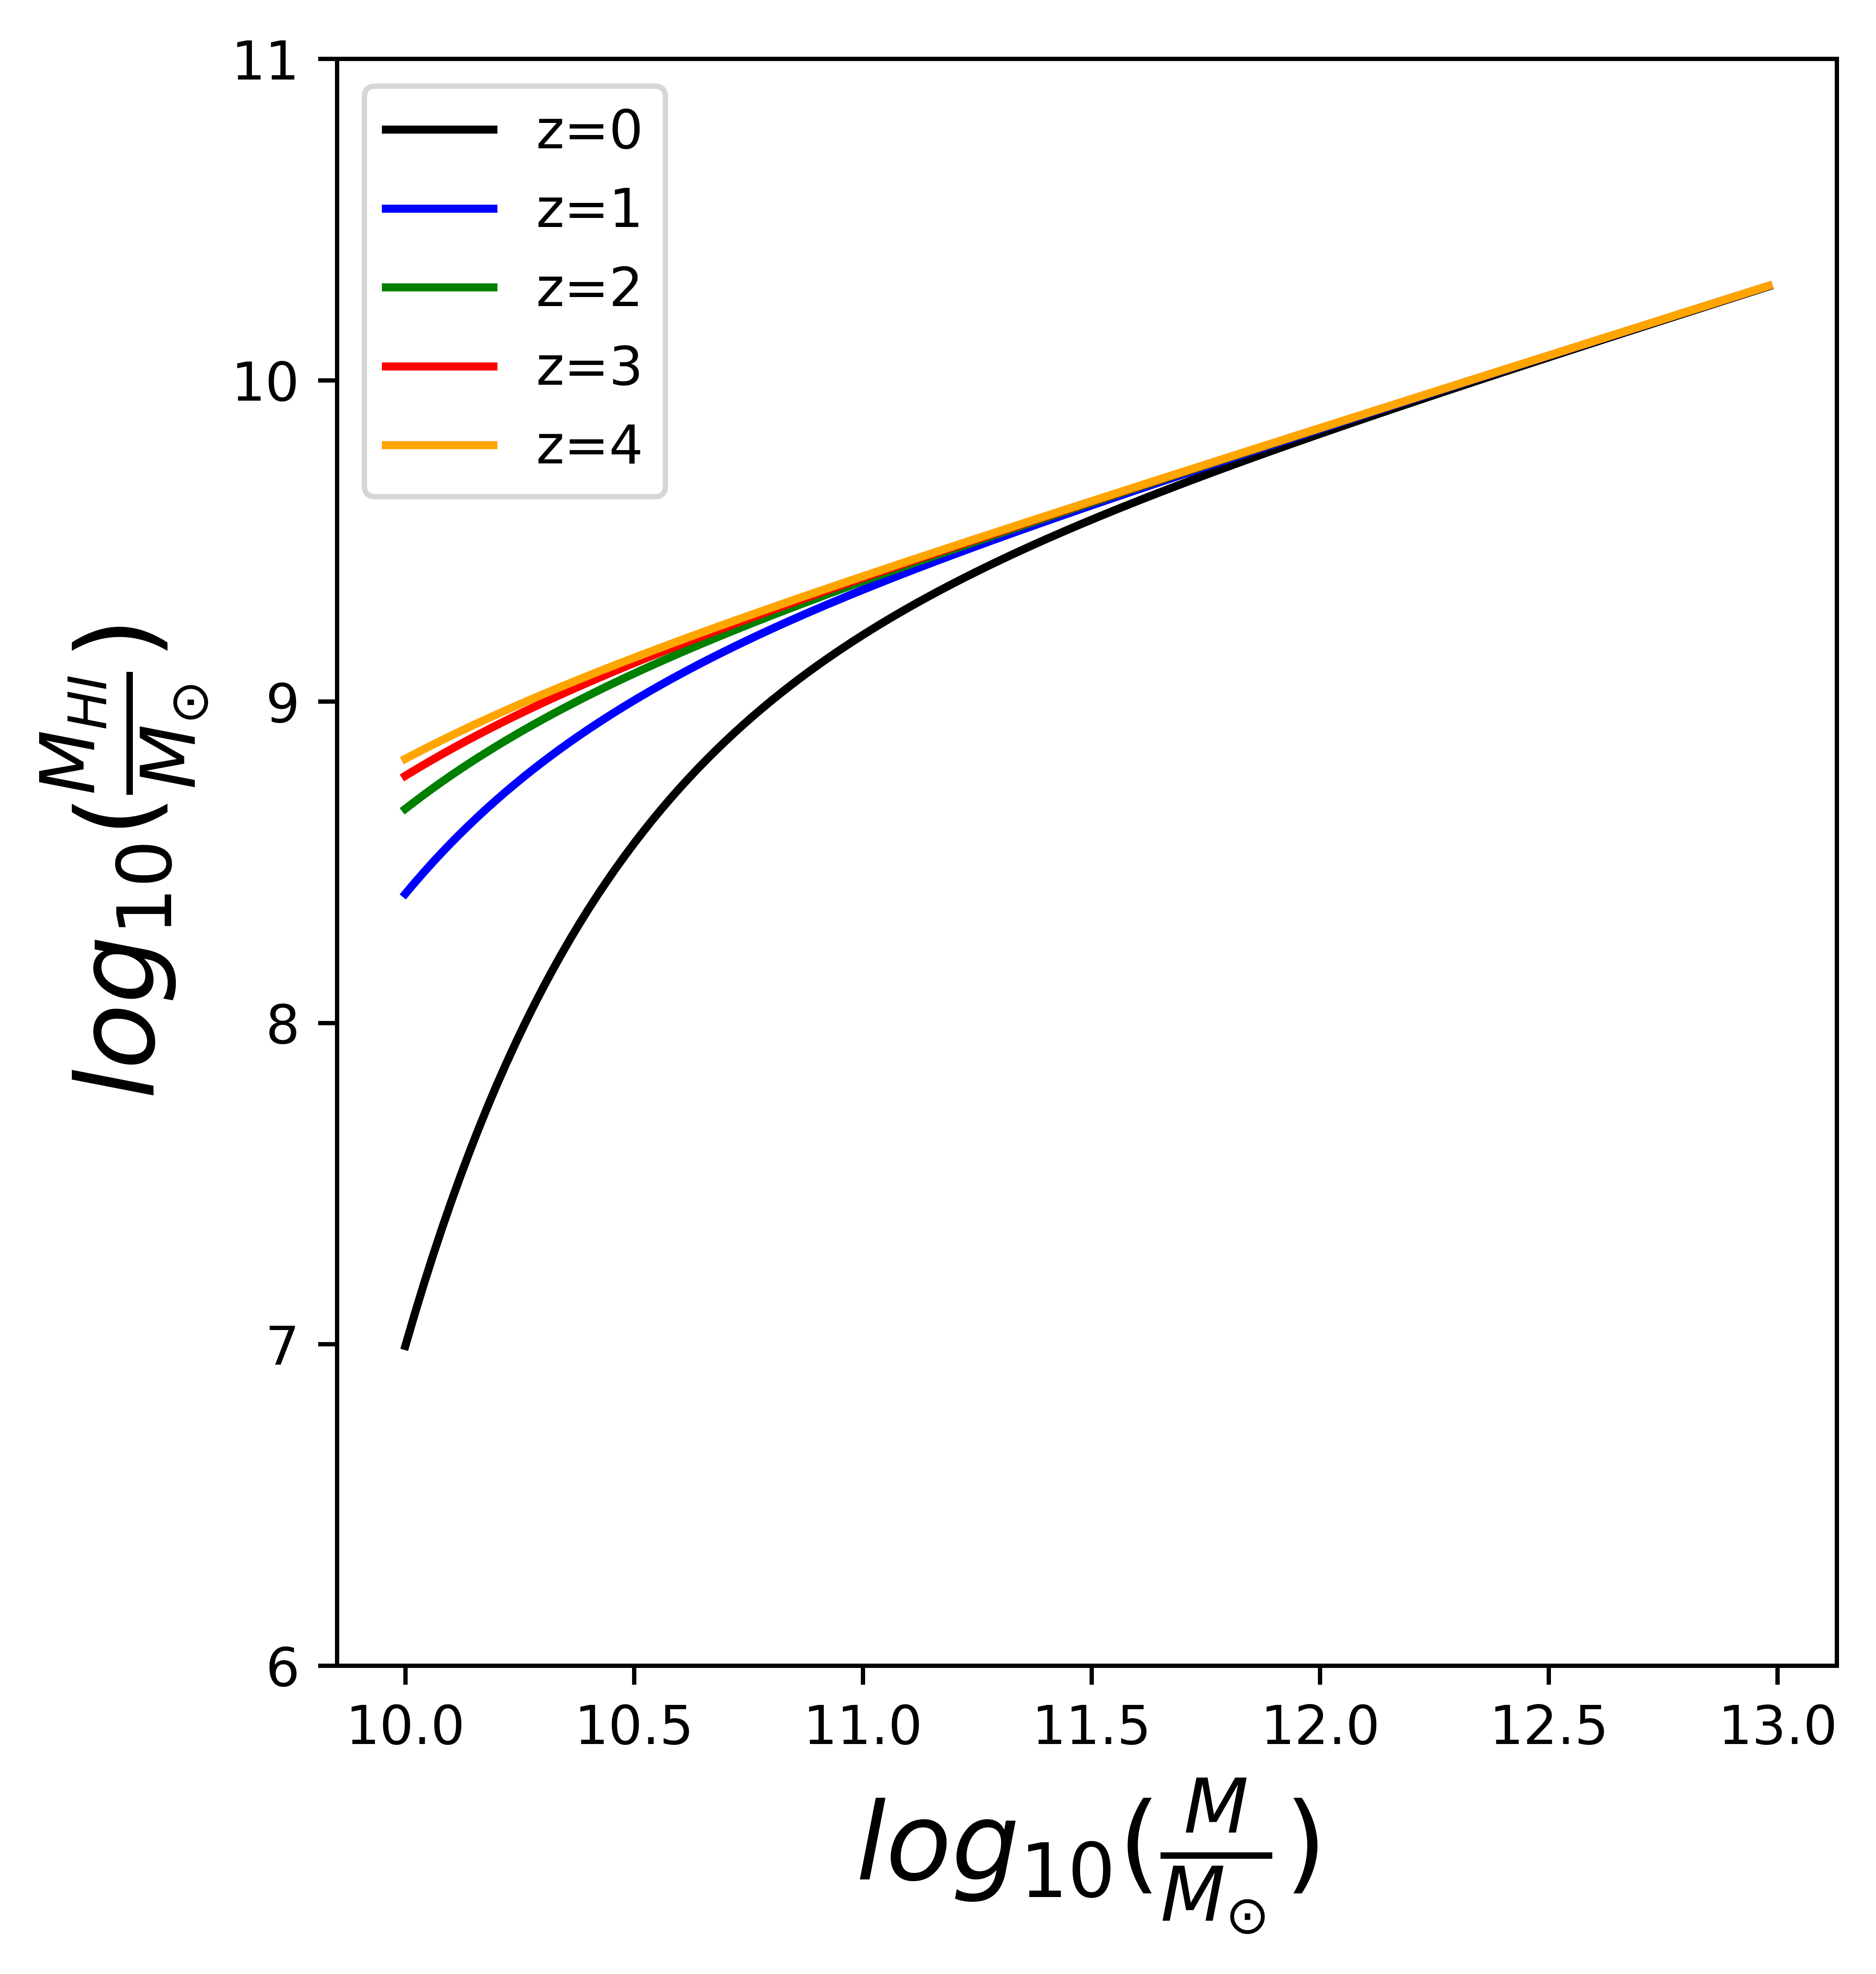

In [80]:
params = cosmology.cosmologies['planck15']
params['Om0'] = 0.281
params['Ob0'] = 0.0462
params['Ode0'] = 0.719
params['H0'] = 71
cosmo = cosmology.setCosmology('planck15',params)


# Parámetros del paper (Best fit (WHISP))
Omega_m = 0.281
Omega_b = 0.0462
Omega_lambda = 0.719
h = 0.71
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s
M=10**np.arange(10,13,0.02)  #En unidades solares



z = 0
Delta_c=mass_so.deltaVir(z)
print(Delta_c)
Masa_HI_0=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=1
Delta_c=mass_so.deltaVir(z)
print(Delta_c)
Masa_HI_1=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=2
Delta_c=mass_so.deltaVir(z)
print(Delta_c)
Masa_HI_2=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=3
Delta_c=mass_so.deltaVir(z)
print(Delta_c)
Masa_HI_3=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)

z=4
Delta_c=mass_so.deltaVir(z)
print(Delta_c)
Masa_HI_4=M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)


plt.figure(figsize=(5, 5.5), dpi=900)
plt.plot(np.log10(M),np.log10(Masa_HI_0),'k-',label='z=0')
plt.plot(np.log10(M),np.log10(Masa_HI_1),'b-',label='z=1')
plt.plot(np.log10(M),np.log10(Masa_HI_2),'g-',label='z=2')
plt.plot(np.log10(M),np.log10(Masa_HI_3),'r-',label='z=3')
plt.plot(np.log10(M),np.log10(Masa_HI_4),color='orange',label='z=4')
plt.xlabel(r'$log_{10}(\frac{M}{M_{\odot}})$',fontsize=20)
plt.ylabel(r'$log_{10}(\frac{M_{HI}}{M_{\odot}})$',fontsize=20)
plt.legend()
plt.ylim([6,11])
#ax = plt.gca()
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.savefig('Plots/Ultimos_graficos/MHI_M_teorica.png',dpi=300,bbox_inches='tight')
plt.show()

Usando el comando de colossus de sobredensidad esférica parece cuadrar con el paper de Padmanabhan. Esta sobredensidad se basa en el paper de Bryan & Norman 1998, que es la misma que la que había usado en el caso anterior, pero esta será más precisa.

In [ ]:
#Vamos a comparar las 3 sobredensidades críticas.
z=np.linspace(0,10,100,endpoint=True)
plt.figure()
plt.title('Sobredensidades críticas')
plt.xlabel('z')
plt.ylabel(r'$\Delta_{c}$',fontsize=15)
plt.plot(z,np.full(len(z), 200),'r',label='crit 200')
plt.plot(z,Delt_c(Omega_m,Omega_lambda,z),'b',label='Manual')
plt.plot(z,mass_so.deltaVir(z),'k',label='Colossus')
plt.legend()
plt.show()

In [ ]:
def vc(M,Omega_m,Omega_lambda,h,z):
    Delta_c = mass_so.deltaVir(z)
    v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    return v_c

In [ ]:
# Parámetros del paper (Best fit (WHISP))
Omega_m = 0.281
Omega_b = 0.0462
Omega_lambda = 0.719
h = 0.71
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s
M=10**np.arange(10,13,0.02)  #En unidades solares


z = 0
v_c_0=vc(M,Omega_m,Omega_lambda,h,z)

z=1
v_c_1=vc(M,Omega_m,Omega_lambda,h,z)

z=2
v_c_2=vc(M,Omega_m,Omega_lambda,h,z)

z=3
v_c_3=vc(M,Omega_m,Omega_lambda,h,z)

z=4
v_c_4=vc(M,Omega_m,Omega_lambda,h,z)


plt.figure()
plt.loglog(M,v_c_0,label='z=0')
plt.loglog(M,v_c_1,label='z=1')
plt.loglog(M,v_c_2,label='z=2')
plt.loglog(M,v_c_3,label='z=3')
plt.loglog(M,v_c_4,label='z=4')
plt.xlabel(r'$\frac{M}{M_{\odot}}$',fontsize=25)
plt.ylabel(r'$v_{virial}(M)$',fontsize=25)
plt.legend()
plt.show()

El sentido físico de que la velocidad virial disminuya con el redshift. Según la teoría de formación jerárquica, en general los halos van ganando masa en su evolución, así que para redshifts bajos tendrán más masa. Esto a su vez hace que para que puedan estar en equilibrio virial, la dispersión de velocidades tenga que ser más alta para poder resistir la atracción gravitatoria y no colapsar.

---------------------------------------------------------------------------